In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files


In [ ]:
uploaded = files.upload()


Saving dataset.csv to dataset.csv


In [ ]:
import io

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

In [ ]:
df

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


In [ ]:
df["Timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], format="%d-%m-%Y %H:%M:%S")
df["Hour"] = df["Timestamp"].dt.hour
df["DayOfWeek"] = df["Timestamp"].dt.dayofweek

In [ ]:
# Feature Mappings
vehicle_weight_map = {'car': 1.0, 'bike': 0.5, 'bus': 1.5, 'truck': 1.8}
traffic_score_map = {"low": 0.3, "medium": 0.6, "high": 1.0}
df["VehicleTypeWeight"] = df["VehicleType"].map(vehicle_weight_map).fillna(1.0)
df["TrafficScore"] = df["TrafficConditionNearby"].map(traffic_score_map).fillna(0.5)
df = df.sort_values(by="Timestamp").reset_index(drop=True)

In [ ]:
# Model 1: Smoothed Linear Model
BASE_PRICE = 10
alpha = 2
smoothing_factor = 0.6
prices_model1 = [BASE_PRICE]
for i in range(1, len(df)):
    occ = df.loc[i, "Occupancy"]
    cap = df.loc[i, "Capacity"]
    raw_price = prices_model1[-1] + alpha * (occ / cap)
    smoothed_price = smoothing_factor * prices_model1[-1] + (1 - smoothing_factor) * raw_price
    prices_model1.append(smoothed_price)
df["Price_Model_1"] = prices_model1


In [ ]:
# Model 2: Demand-Based Dynamic Pricing
α, β, γ, δ, ε, λ = 1.0, 0.5, 0.7, 1.0, 0.8, 0.6
df["RawDemand"] = (
    α * (df["Occupancy"] / df["Capacity"]) +
    β * df["QueueLength"] -
    γ * df["TrafficScore"] +
    δ * df["IsSpecialDay"] +
    ε * df["VehicleTypeWeight"] +
    0.2 * (df["Hour"] / 24.0)
)

In [ ]:
# Normalize demand per parking lot
def normalize_per_lot(sub_df):
    min_d, max_d = sub_df["RawDemand"].min(), sub_df["RawDemand"].max()
    sub_df["NormalizedDemand"] = (sub_df["RawDemand"] - min_d) / (max_d - min_d + 1e-6)
    return sub_df


In [ ]:
df = df.groupby("SystemCodeNumber").apply(normalize_per_lot).reset_index(drop=True)
df["Price_Model_2"] = (BASE_PRICE * (1 + λ * df["NormalizedDemand"])).clip(lower=5, upper=20)


/tmp/ipython-input-12-4219864695.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("SystemCodeNumber").apply(normalize_per_lot).reset_index(drop=True)


In [ ]:
# Model 3: Competition-Aware Pricing
coords = df[["Latitude", "Longitude"]].values
nn = NearestNeighbors(radius=0.01, algorithm="ball_tree").fit(coords)
_, indices = nn.radius_neighbors(coords)


In [ ]:
nearby_avg_prices = []
for i, neighbors in enumerate(indices):
    neighbors = [n for n in neighbors if n != i]
    if neighbors:
        avg_price = df.loc[neighbors, "Price_Model_2"].mean()
    else:
        avg_price = df.loc[i, "Price_Model_2"]
    nearby_avg_prices.append(avg_price)
df["NearbyAvgPrice"] = nearby_avg_prices


In [ ]:
def competitive_price(row):
    p2 = row["Price_Model_2"]
    p_nearby = row["NearbyAvgPrice"]
    occ_ratio = row["Occupancy"] / row["Capacity"]
    if occ_ratio > 0.9 and p_nearby < p2:
        return p2 * 0.9
    elif p_nearby > p2:
        return min(p2 * 1.1, 20)
    else:
        return p2


In [ ]:
df["Price_Model_3"] = df.apply(competitive_price, axis=1)

In [ ]:
# Visualization: Bokeh
sample_lot = df["SystemCodeNumber"].iloc[0]
df_lot = df[df["SystemCodeNumber"] == sample_lot]

p = figure(x_axis_type="datetime", title=f"Price Models Over Time – Lot: {sample_lot}", width=800, height=350)
p.line(df_lot["Timestamp"], df_lot["Price_Model_1"], color="blue", line_width=2, legend_label="Model 1")
p.line(df_lot["Timestamp"], df_lot["Price_Model_2"], color="green", line_width=2, legend_label="Model 2")
p.line(df_lot["Timestamp"], df_lot["Price_Model_3"], color="red", line_width=2, legend_label="Model 3")
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price"
p.legend.location = "top_left"
show(p)


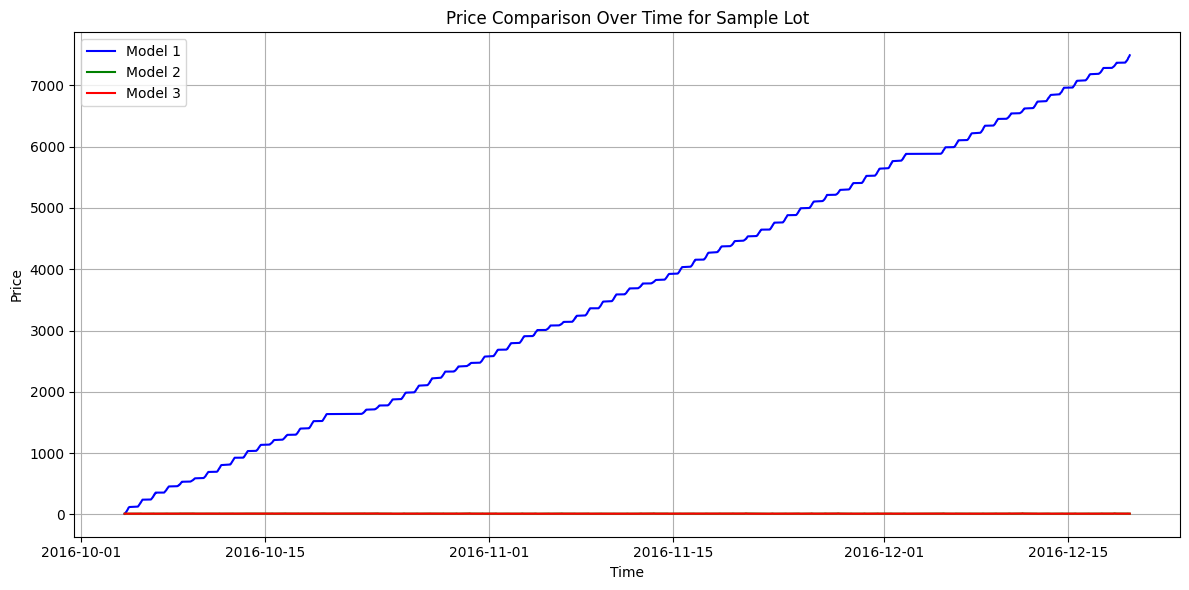

In [ ]:
# Visualization: Matplotlib (static & exportable)
plt.figure(figsize=(12, 6))
plt.plot(df_lot["Timestamp"], df_lot["Price_Model_1"], label="Model 1", color='blue')
plt.plot(df_lot["Timestamp"], df_lot["Price_Model_2"], label="Model 2", color='green')
plt.plot(df_lot["Timestamp"], df_lot["Price_Model_3"], label="Model 3", color='red')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Comparison Over Time for Sample Lot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("price_plot.png")
plt.show()


In [ ]:
df.to_csv("final_pricing_output.csv", index=False)

In [ ]:
from google.colab import files
files.download("final_pricing_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>